In this notebook, we will do some plots to estimate redshift results for 3 methods below:
1. bliss redshift estimate directly from images
2. redshift estimate based on GT mag 
3. redshift estimate based on LSST predicted flux

each plot should have metrics vs galaxy fluxes

In [5]:
import torch
from os import environ
from pathlib import Path
from einops import rearrange
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import FullCatalog, BaseTileCatalog, TileCatalog
from bliss.surveys.dc2 import DC2, unsqueeze_tile_dict
from case_studies.redshift.evaluation.utils.load_lsst import get_lsst_full_cat
from case_studies.redshift.evaluation.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.redshift.redshift_from_img.encoder.metrics import RedshiftMeanSquaredErrorBin

environ["BLISS_HOME"] = str(Path().resolve().parents[2])

output_dir = Path("./DC2output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "/home/qiaozhih/bliss/case_studies/redshift/redshift_from_img/DC2_redshift_training/DC2_redshift_only_bin/checkpoints/encoder_0.174964.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [6]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_plot")

In [7]:
# set up testing dataset
dataset = instantiate(notebook_cfg.train.data_source)
dataset.setup()


# example of test dataset

In [ ]:
len(dataset.image_ids())

In [ ]:
len(dataset.test_dataset)

In [ ]:
x = 0
for i in dataset.test_dataset:
    x = i
    break

In [ ]:
x['tile_catalog']['redshifts'].shape

In [ ]:
x["split_id"]

In [ ]:
x["images"].shape

### 1. bliss redshift estimate directly from images

In [8]:
# Loop through the test set and update the metric
# load bliss trained model
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();
# for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
#     batch["images"] = batch["images"].to(device)
#     bliss_encoder.update_metrics(batch, batch_idx)

# bliss_out_dict = bliss_encoder.mode_metrics.compute()

In [9]:
bliss_output_path = output_dir / "bliss_output_all.pkl"

if not bliss_output_path.exists():
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        batch["images"] = batch["images"].to(device)
        bliss_encoder.update_metrics(batch, batch_idx)
    bliss_out_dict = bliss_encoder.mode_metrics.compute()

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

100%|██████████| 383/383 [06:04<00:00,  1.05it/s]

total num of pts: tensor([54577., 29581., 10163.,  5388.,  3120., 15162.], device='cuda:0')


In [12]:
bliss_out_dict

{'redshifts/bias_bin_0': -0.01940205879509449,
 'redshifts/bias_bin_1': -0.014454119838774204,
 'redshifts/bias_bin_2': -0.012397130951285362,
 'redshifts/bias_bin_3': -0.0178708266466856,
 'redshifts/bias_bin_4': -0.016601406037807465,
 'redshifts/bias_bin_5': -0.02073412574827671,
 'redshifts/mse_bin_0': 0.27121469378471375,
 'redshifts/mse_bin_1': 0.13976307213306427,
 'redshifts/mse_bin_2': 0.07524657994508743,
 'redshifts/mse_bin_3': 0.057453203946352005,
 'redshifts/mse_bin_4': 0.05058649182319641,
 'redshifts/mse_bin_5': 0.03236730396747589,
 'redshifts/nmad_bin_0': 0.18206419050693512,
 'redshifts/nmad_bin_1': 0.11283144354820251,
 'redshifts/nmad_bin_2': 0.07652566581964493,
 'redshifts/nmad_bin_3': 0.06236919015645981,
 'redshifts/nmad_bin_4': 0.0593399852514267,
 'redshifts/nmad_bin_5': 0.042008381336927414,
 'redshifts/outlier_fraction_bin_0': 0.4209282398223877,
 'redshifts/outlier_fraction_bin_1': 0.26364895701408386,
 'redshifts/outlier_fraction_bin_2': 0.158417791128158

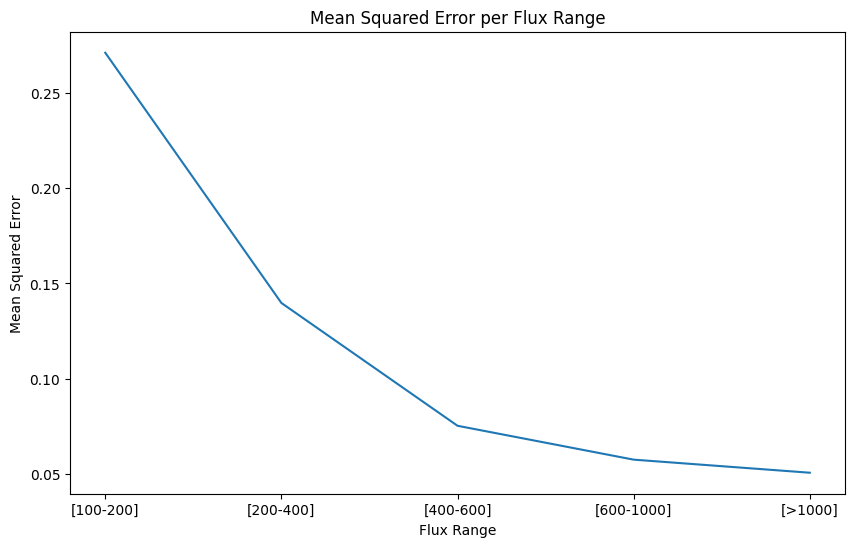

In [13]:
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
mse_values = [bliss_out_dict[f'redshifts/mse_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, mse_values)
plt.xlabel('Flux Range')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Flux Range')
plt.show()


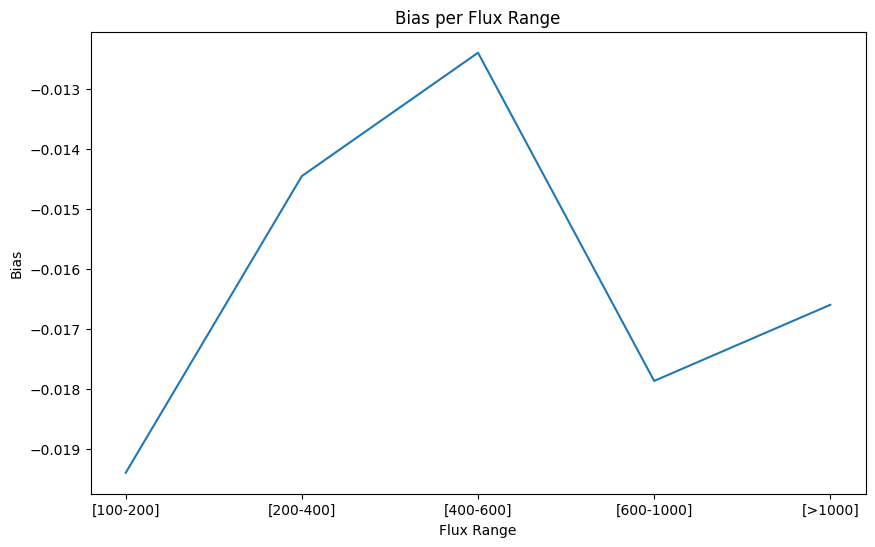

In [33]:
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
bias_values = [bliss_out_dict[f'redshifts/bias_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, bias_values)
plt.xlabel('Flux Range')
plt.ylabel('Bias')
plt.title('Bias per Flux Range')
plt.show()

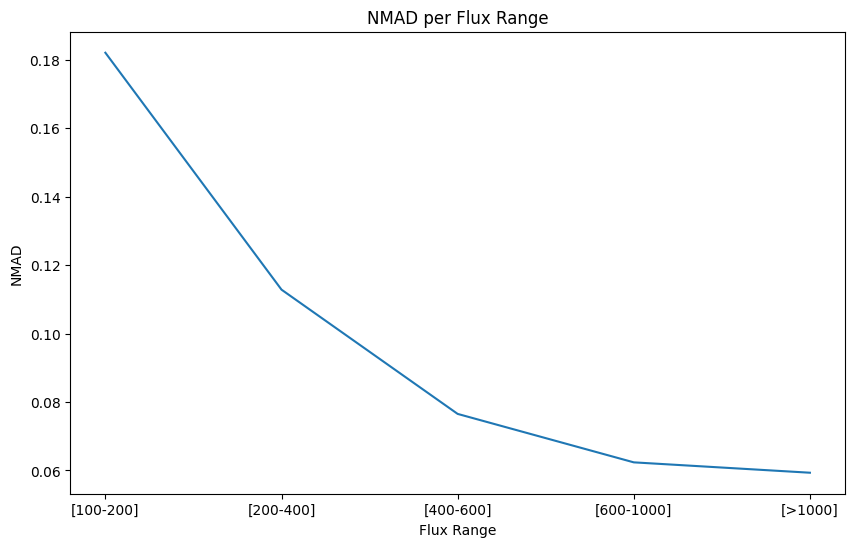

In [15]:
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
nmad_values = [bliss_out_dict[f'redshifts/nmad_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, nmad_values)
plt.xlabel('Flux Range')
plt.ylabel('NMAD')
plt.title('NMAD per Flux Range')
plt.show()

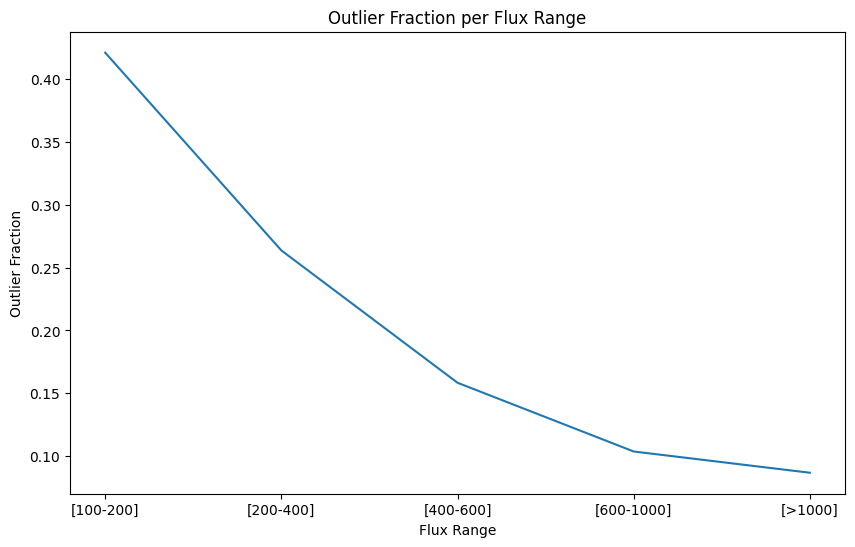

In [34]:
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
outlier_fraction_values = [bliss_out_dict[f'redshifts/outlier_fraction_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, outlier_fraction_values)
plt.xlabel('Flux Range')
plt.ylabel('Outlier Fraction')
plt.title('Outlier Fraction per Flux Range')
plt.show()


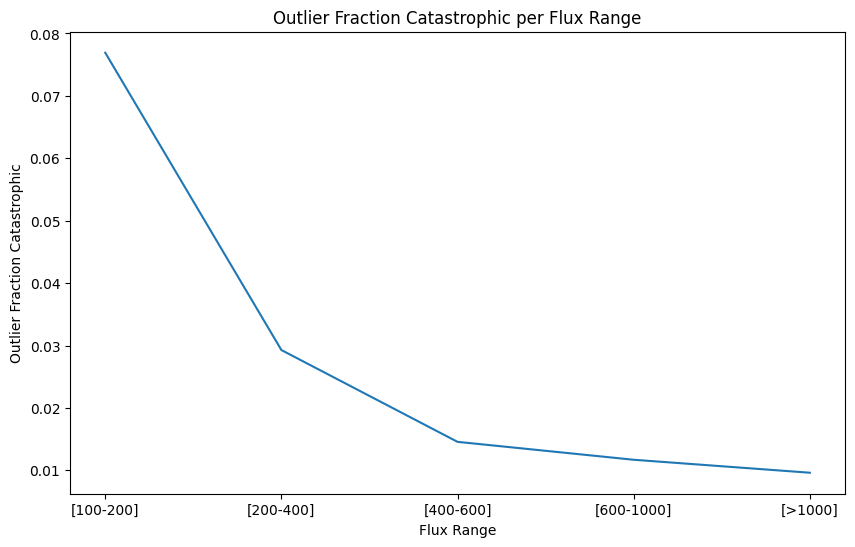

In [18]:
flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
outlier_fraction_cata_values = [bliss_out_dict[f'redshifts/outlier_fraction_cata_bin_{i}'] for i in range(5)]

plt.figure(figsize=(10, 6))
plt.plot(flux_ranges, outlier_fraction_cata_values)
plt.xlabel('Flux Range')
plt.ylabel('Outlier Fraction Catastrophic')
plt.title('Outlier Fraction Catastrophic per Flux Range')
plt.show()

### 2. redshift estimate based on GT mag

In [19]:
from case_studies.redshift.network_rs import PhotoZFromMag
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn

In [20]:
num_bins = 1
group_size = 128
batch_size = 1
in_dim = 6
device = "cuda"
path = "/home/qiaozhih/bliss/case_studies/redshift/training_runs/00120-run/tensorboard_logs/version_0/checkpoints/reg_val_loss=0.000367_epoch=29.ckpt"
network_options = {
    "hidden_dim": 256,
    "out_dim": num_bins,
    "n_epochs": 50001,
    "outdir": "/home/qiaozhih/bliss/case_studies/redshift/training_runs/",
    "snap": 1,  # how many epoches to save one model once
    "loss_fcn": torch.nn.MSELoss(),  # loss func
    # 'loss_fcn': torch.nn.CrossEntropyLoss(),                     # loss func
    "dropout_rate": 0.5,
    "learning_rate": 1e-3,
    "group_size": group_size,
    "num_gpu": 1,
    "gpu_device": [0],
}

In [21]:
reg = PhotoZFromMag(
    in_dim,
    network_options["hidden_dim"],
    network_options["out_dim"],
    network_options["dropout_rate"],
    network_options["learning_rate"],
    network_options["loss_fcn"],
)
reg = reg.load_from_checkpoint(
    path,
    in_dim=in_dim,
    hidden_dim=network_options["hidden_dim"],
    out_dim=network_options["out_dim"],
    dropout_rate=network_options["dropout_rate"],
    learning_rate=network_options["learning_rate"],
    loss_fcn=network_options["loss_fcn"],
)
reg.to(device)
reg.eval()

PhotoZFromMag(
  (loss_fcn): MSELoss()
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [22]:
def est_redshifts_with_reg_change_to_cat(true_cat: TileCatalog, reg: PhotoZFromMag, tile_slen: int) -> BaseTileCatalog:
    """estimate redshift by inputting true mag using regressor, then convert them to Basetilecatalog

    Args:
        true_cat: true_catalog
        reg: regressor that accept ugrizy mag

    Returns:
        Catalog that containing pred redshifts
    """
    true_mag = true_cat.magnitudes_njy.to(device)
    new_order = [3, 0, 2, 1, 5, 4] # change giruyz to ugrizy
    true_mag = true_mag[..., new_order]
    true_is_galaxy = true_cat.galaxy_bools.to(device)
    N, H, W, M, _ = true_mag.shape
    true_mag = true_mag.reshape(-1, 6)
    true_is_galaxy = true_is_galaxy.reshape(-1, 1)
    pred_rs = torch.zeros_like(true_mag[..., 0])
    for i in range(len(true_mag)):
        if true_is_galaxy[i][0]: 
            x = true_mag[i].unsqueeze(0) # 1, 6
            a = reg.net(x) # 1, 1
            pred_rs[i] = reg.net(true_mag[i].unsqueeze(0)).squeeze(0)
    pred_rs = {"redshifts": pred_rs.reshape((N, H, W, M, 1))}

    return BaseTileCatalog(tile_slen=tile_slen, d=pred_rs)

GT data preparation

In [23]:
gt_output_path = output_dir / "gt_output_all.pkl"
if not gt_output_path.exists():
    metrics = instantiate(notebook_cfg.encoder.metrics)
    matcher = instantiate(notebook_cfg.encoder.matcher)
    metrics.reset()
    for batch_idx, batch in tqdm(enumerate(dataset.test_dataloader()), total=len(dataset.test_dataloader())):
        true_cat = TileCatalog(tile_slen=4, d=batch["tile_catalog"]) # TODO tile_slen
        est_cat = est_redshifts_with_reg_change_to_cat(true_cat, reg, tile_slen=4)# TODO
        matching = matcher.match_catalogs(true_cat, est_cat)
        metrics.update(true_cat, est_cat, matching)

    gt_out_dict = metrics.compute()

    with open(gt_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(gt_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(gt_output_path, "rb") as inputp:
        gt_out_dict = pickle.load(inputp)

100%|██████████| 383/383 [06:24<00:00,  1.00s/it]

total num of pts: tensor([67468., 36486., 12573.,  6674.,  3875., 18732.])


In [35]:
bliss_out_dict

{'redshifts/bias_bin_0': -0.01940205879509449,
 'redshifts/bias_bin_1': -0.014454119838774204,
 'redshifts/bias_bin_2': -0.012397130951285362,
 'redshifts/bias_bin_3': -0.0178708266466856,
 'redshifts/bias_bin_4': -0.016601406037807465,
 'redshifts/bias_bin_5': -0.02073412574827671,
 'redshifts/mse_bin_0': 0.27121469378471375,
 'redshifts/mse_bin_1': 0.13976307213306427,
 'redshifts/mse_bin_2': 0.07524657994508743,
 'redshifts/mse_bin_3': 0.057453203946352005,
 'redshifts/mse_bin_4': 0.05058649182319641,
 'redshifts/mse_bin_5': 0.03236730396747589,
 'redshifts/nmad_bin_0': 0.18206419050693512,
 'redshifts/nmad_bin_1': 0.11283144354820251,
 'redshifts/nmad_bin_2': 0.07652566581964493,
 'redshifts/nmad_bin_3': 0.06236919015645981,
 'redshifts/nmad_bin_4': 0.0593399852514267,
 'redshifts/nmad_bin_5': 0.042008381336927414,
 'redshifts/outlier_fraction_bin_0': 0.4209282398223877,
 'redshifts/outlier_fraction_bin_1': 0.26364895701408386,
 'redshifts/outlier_fraction_bin_2': 0.158417791128158

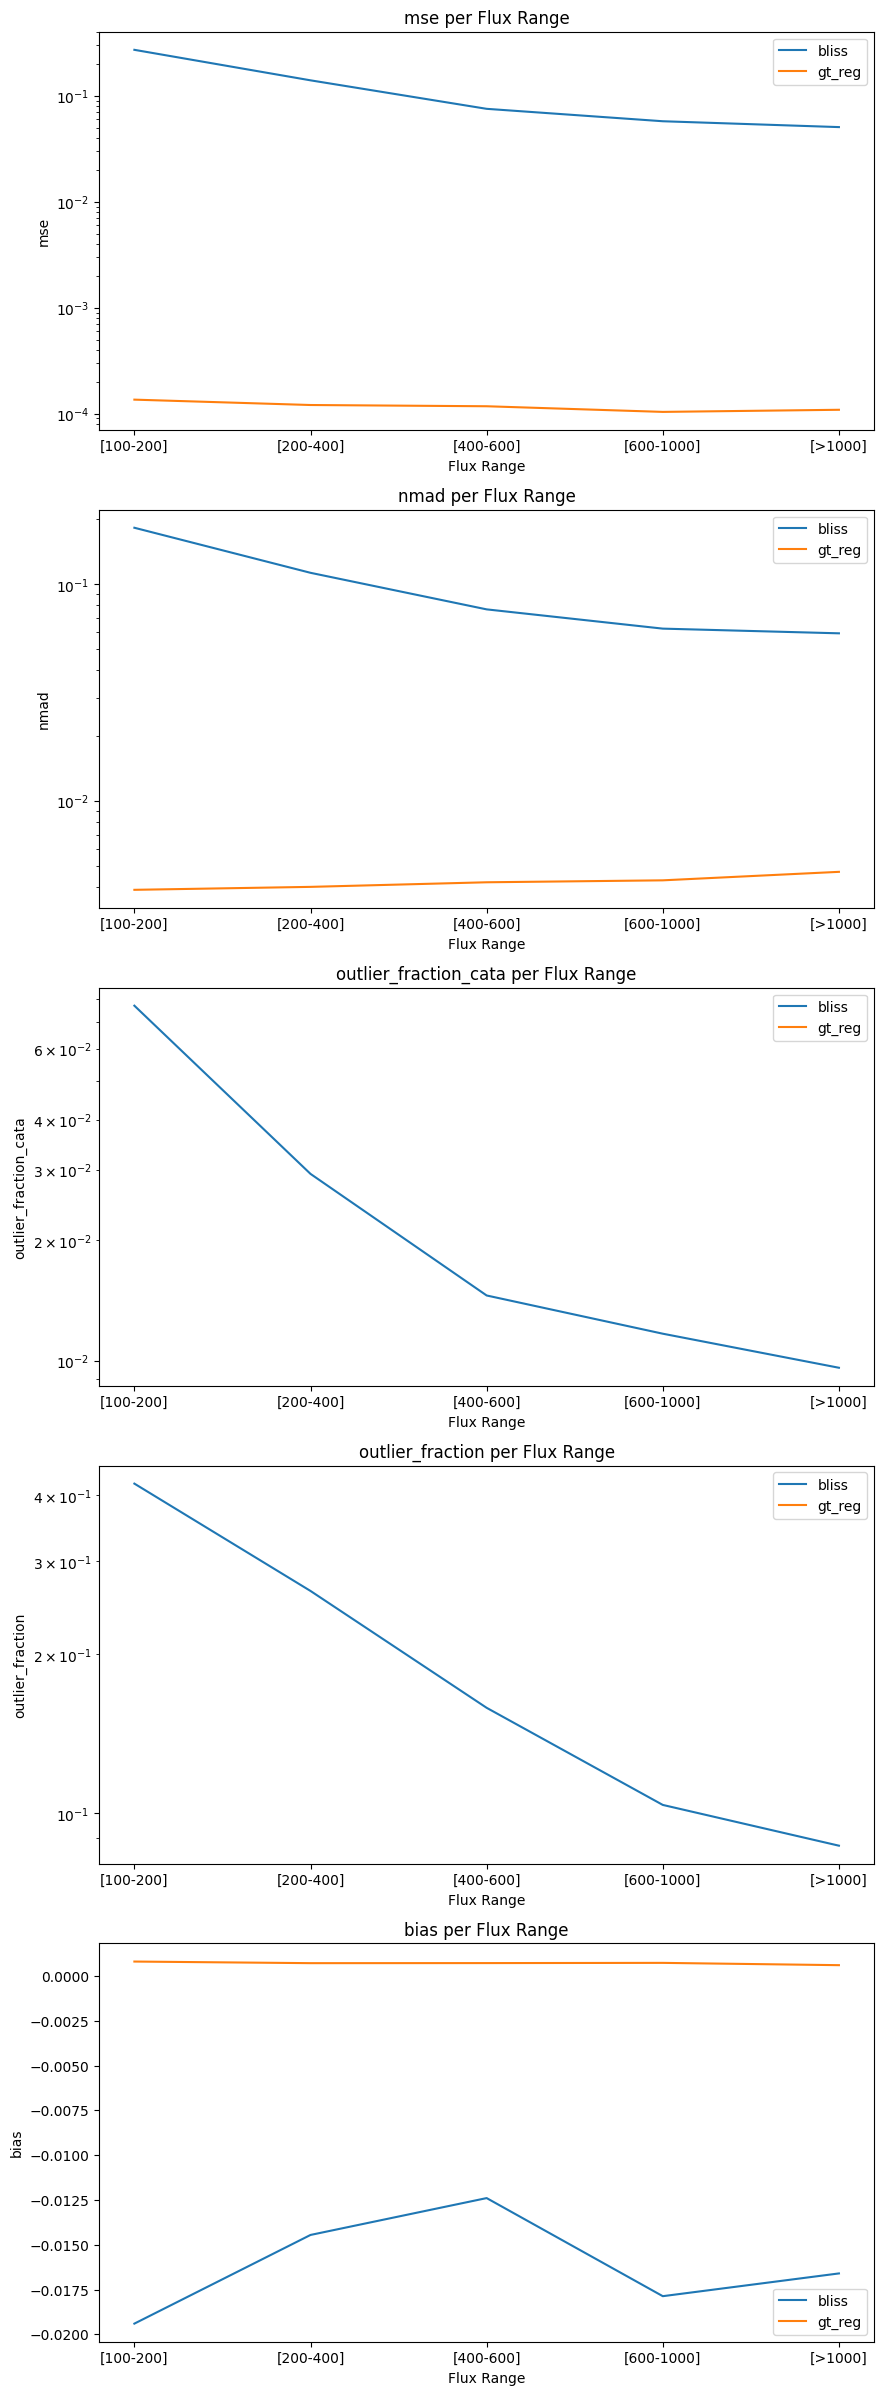

In [37]:
metrics = ['mse', 'nmad', 'outlier_fraction_cata', 'outlier_fraction', 'bias']
fig, ax = plt.subplots(len(metrics), figsize=(10, 30))
for i, metric in enumerate(metrics):
    flux_ranges = ['[100-200]', '[200-400]', '[400-600]', '[600-1000]', '[>1000]']
    gt_mse_values = [gt_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(5)]
    bliss_mse_values = [bliss_out_dict[f'redshifts/{metric}_bin_{i}'] for i in range(5)]

    ax[i].plot(flux_ranges, bliss_mse_values, label="bliss")
    ax[i].plot(flux_ranges, gt_mse_values, label="gt_reg")
    if metric != 'bias':
        ax[i].set_yscale("log")
    ax[i].set_xlabel('Flux Range')
    ax[i].set_ylabel(metric)
    ax[i].set_title(f'{metric} per Flux Range')
    ax[i].legend()
plt.show()

In [30]:
gt_out_dict

{'redshifts/bias_bin_0': 0.0008017609361559153,
 'redshifts/bias_bin_1': 0.0007119826623238623,
 'redshifts/bias_bin_2': 0.0007159098167903721,
 'redshifts/bias_bin_3': 0.0007279749261215329,
 'redshifts/bias_bin_4': 0.000599693797994405,
 'redshifts/bias_bin_5': 0.001286372309550643,
 'redshifts/mse_bin_0': 0.00013550283620133996,
 'redshifts/mse_bin_1': 0.00012056977720931172,
 'redshifts/mse_bin_2': 0.00011736601300071925,
 'redshifts/mse_bin_3': 0.00010382600157754496,
 'redshifts/mse_bin_4': 0.0001087068667402491,
 'redshifts/mse_bin_5': 0.00012679805513471365,
 'redshifts/nmad_bin_0': 0.0038930890150368214,
 'redshifts/nmad_bin_1': 0.004017178900539875,
 'redshifts/nmad_bin_2': 0.004218028858304024,
 'redshifts/nmad_bin_3': 0.0043058982118964195,
 'redshifts/nmad_bin_4': 0.004712411668151617,
 'redshifts/nmad_bin_5': 0.005075711291283369,
 'redshifts/outlier_fraction_bin_0': 0.0,
 'redshifts/outlier_fraction_bin_1': 0.0,
 'redshifts/outlier_fraction_bin_2': 0.0,
 'redshifts/outli

### 3. redshift estimate based on LSST predicted flux

In [ ]:
# load lsst data
lsst_full_cat = get_lsst_full_cat(lsst_root_dir=lsst_root_dir,
                                  cur_image_wcs=cur_image_wcs,
                                  image_lim=image_lim,
                                  r_band_min_flux=r_band_min_flux,
                                  device=device)